# Introduction and Background

This notebook is meant to teach some of the basic functionality of Pandas by using a hydrologic dataset to answer a couple simple questions about the behavior of the Glen Canyon Dam on the Colorado River. A short signal processing example is also included to make use of the dataset and illustrate Fast Fourier Transforms in numpy.

The [Colorado River Compact](https://en.wikipedia.org/wiki/Colorado_River_Compact).  mandates there should be 7.5E6 Acre-feet /year of flow at Lee's Ferry to deliver the [Compact](https://www.usbr.gov/lc/region/pao/pdfiles/crcompct.pdf)-mandated from the upper basin to the lower basin. This requirement has been in existence since 1922 and USGS has maintained a [streamgage](https://waterdata.usgs.gov/nwis/uv?09380000) there since 1921. 


 <img width="500" src="Glen_Canyon_Dam_Lake_Powell,_Arizona.jpeg">
 
In 1967, The [Glen Canyon Dam](https://www.usbr.gov/uc/rm/crsp/gc/) was filled (construction took place between 1956 and 1966)  in part to ensure this mandated delivery from the upper basin to the lower basin, as well as to generate electricity.


In this notebook, we will use Pandas and Numpy to analyze the streamgage data and explore the behavior of the river with respect to the presence of the dam.

  1. Pull the data from USGS webservices
  2. Munge the data and convert units to prepare for analysis 
  3. Examine the data to explore the impact of the dam on meeting the compact and river behavior
  4. Using a fast-Fourier transform, analyze the signal properties of flow with the dam in place


# 0. import the python packages that will be needed for analysis

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import detrend as sp_detrend
import matplotlib.pyplot as plt
import os
import requests
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
sns.set()
%matplotlib inline


# 1. Pulling the data into a pandas DataFrame

We already know the site number for Lee's Ferry is 09380000. Now we need to construct a waterservices URL to use Pandas to download the data. And, of course, there will be necessary data munging and unit conversion.

In [2]:
# the URL is just a long string
site_num = '09380000'

dv_url = 'http://waterservices.usgs.gov/nwis/dv/?format=rdb'
dv_url += '&sites={0}'.format(site_num)
#dv_url += '&startDT=2010-01-01'
dv_url += '&startDT=1880-01-01'
#dv_url += '&endDT=2018-01-17'
dv_url += '&parameterCd=00060'
print(dv_url)


http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=09380000&startDT=1880-01-01&parameterCd=00060


### now, ideally, we could just pull the data directly with Pandas, but it is a little tricky to handle the header
### So, we can use `requests` to download a text file first.

In [3]:
print ('reading data for {0}'.format(site_num))
dv_file = requests.get(dv_url)

with open('{0}.dat'.format(site_num), 'w') as ofp:
    for line in dv_file:
        ofp.write(line.decode())

reading data for 09380000


### now just look at the header lines

In [4]:
file_data = open('{0}.dat'.format(site_num), 'r').readlines()
for i in np.arange(40):
    print (file_data[i].rstrip())

# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database may not
# have received Director's approval.  Any such data values are qualified as provisional and
# are subject to revision.  Provisional data are released on the condition that neither the
# USGS nor the United States Government may be held liable for any damages resulting from its use.
#  Go to http://help.waterdata.usgs.gov/policies/provisional-data-statement for more information.
#
# File-format description:  http://help.waterdata.usgs.gov/faq/about-tab-delimited-output
# Automated-retrieval info: http://help.waterdata.usgs.gov/faq/automated-retrievals
#
# Contact:   gs-w_support_nwisweb@usgs.gov
# retrieved: 2022-03-20 22:25:10 -04:00	(natwebvaas01)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 09380000 COLORADO RIVER AT LEES FERRY, AZ
# -----------------------------------------------

### this gets tricky with USGS NWIS data because the column names are followed by a code that contains metadata that we don't need. 

We can first read it in as a MultiIndex header (specifying the header to be rows 0 and 1 after the comment lines). We also need to specify that the separator for the columns in the file is a tab (`'\t'`). 

Also, note that we are reading directly from the URL - we could also read from the file we downloaded by passing a filename.

In [5]:
nwis_df = pd.read_csv(dv_url, comment='#', header=[0,1], sep='\t')

### look at the `head` - top 5 rows, and see the columns

In [6]:
nwis_df.head()

,agency_cd,site_no,datetime,236239_00060_00003,236239_00060_00003_cd
,5s,15s,20d,14n,10s
0,USGS,9380000,1921-10-01,7120,A
1,USGS,9380000,1921-10-02,11800,A
2,USGS,9380000,1921-10-03,7830,A
3,USGS,9380000,1921-10-04,7470,A
4,USGS,9380000,1921-10-05,6780,A


### we only want the first row of each column name

In [7]:
nwis_df.columns = [i[0] for i in nwis_df.columns]

In [8]:
nwis_df.head()


,agency_cd,site_no,datetime,236239_00060_00003,236239_00060_00003_cd
0,USGS,9380000,1921-10-01,7120,A
1,USGS,9380000,1921-10-02,11800,A
2,USGS,9380000,1921-10-03,7830,A
3,USGS,9380000,1921-10-04,7470,A
4,USGS,9380000,1921-10-05,6780,A


### and we have to be sure our dates are interpreted as dates 

In [9]:
nwis_df.dtypes

agency_cd                object
site_no                   int64
datetime                 object
236239_00060_00003        int64
236239_00060_00003_cd    object
dtype: object

### initially, they are `object` type, so we can convert them to dates

In [10]:
nwis_df.datetime = pd.to_datetime(nwis_df.datetime)

In [11]:
nwis_df.dtypes

agency_cd                        object
site_no                           int64
datetime                 datetime64[ns]
236239_00060_00003                int64
236239_00060_00003_cd            object
dtype: object

### we want to use the `datetime` column as the index for the dataframe

In [12]:
nwis_df.set_index('datetime',drop=True,inplace=True) 
nwis_df.head()

,agency_cd,site_no,236239_00060_00003,236239_00060_00003_cd
datetime,,,,
1921-10-01,USGS,9380000,7120,A
1921-10-02,USGS,9380000,11800,A
1921-10-03,USGS,9380000,7830,A
1921-10-04,USGS,9380000,7470,A
1921-10-05,USGS,9380000,6780,A


### and finally,  we can drop the column about quality and the agency code and site number as redundant and rename just the flux data with a more meaningful name

In [13]:
nwis_df = nwis_df['236239_00060_00003'].to_frame() # reducing to one column makes this a pandas series, but
                                                # to add columns later, we want it to stay as a DataFrame
nwis_df.columns=['Q']
nwis_df.head()

,Q
datetime,
1921-10-01,7120
1921-10-02,11800
1921-10-03,7830
1921-10-04,7470
1921-10-05,6780


# 2. Now Data Munging
### Note that the data starts on October 1, 1921. This means the start of a USGS concept called "Water Year". It would be good to perform calculations based on the water year.
First, we can make a couple new columns, one for year, and one for water year.

How can we group by water year? Not a very easy Google Kung Fu exercise at first, but what about "Fiscal Year"?
Google "Pandas group by fiscal year"
http://stackoverflow.com/questions/26341272/using-groupby-on-pandas-dataframe-to-group-by-financial-year

In [14]:
#make water year by shifting forward the number of days in Oct., Nov., and Dec.
# NOTE --> shifting by months is less precise
nwis_df['water_year'] = nwis_df.index.shift(30+31+31,freq='d').year

### So now we can add columns with some unit conversions. Recall from the introduction that the Compact is in terms of acre-feet but the metadata from NWIS indicates that we have data in cubic feet per second

### units are $\frac{ft^3}{s}$
### So let's convert to cubic feet per day which we can later sum up by water year
### $\frac{1 ft^3}{s} \times \frac{60s}{min} \times \frac{60min}{hour} \times \frac{24hours}{day} \rightarrow \frac{ft^3}{day}$

### 1 acre-foot = 43559.9 cubic feet

In [15]:
nwis_df['Q_cfd'] = nwis_df.Q * 60 * 60 * 24
nwis_df['Q_af'] = nwis_df.Q_cfd / 43559.9

In [16]:
nwis_df

,Q,water_year,Q_cfd,Q_af
datetime,,,,
1921-10-01,7120,1922,615168000,14122.346470
1921-10-02,11800,1922,1019520000,23405.012408
1921-10-03,7830,1922,676512000,15530.614166
1921-10-04,7470,1922,645408000,14816.562940
1921-10-05,6780,1922,585792000,13447.964757
...,...,...,...,...
2022-03-15,10300,2022,889920000,20429.798966
2022-03-16,10100,2022,872640000,20033.103841
2022-03-17,10200,2022,881280000,20231.451404


# 3. Now we can plot the time series and take a look

<AxesSubplot:xlabel='datetime'>

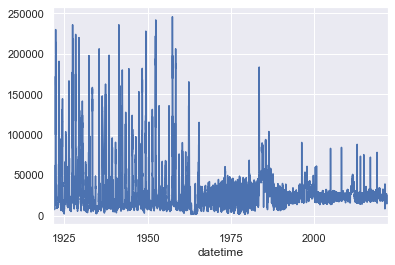

In [17]:
nwis_df['Q_af'].plot()

### we can definitely see some interesting things but might be better to look year-by-year

### using `groupby` we can easily create a multipage Ppdf with each water year being a page of the time series

In [18]:
with PdfPages('wateryear_lees_ferry.pdf') as outpdf:
    for cname, cgroup in nwis_df.groupby('water_year'):
        print('plotting for water year {}\r'.format(cname), end="")
        plt.figure(figsize=(8,6))
        cgroup['Q_af'].plot()
        plt.title('Flow in Acre feet per day for water year {}'.format(cname))
        outpdf.savefig()
        plt.close('all')
        

### open the PDF and check out the patterns. What's going on in the mid-1960s? How about [1983](https://www.simonandschuster.com/books/The-Emerald-Mile/Kevin-Fedarko/9781439159866)? Any big differences in the flow regime before and after the dam?

### We can also aggregate data using `agg` - powerful!
### let's aggregate by water year

In [19]:
wateryear = nwis_df.groupby('water_year').agg(['count','mean','sum'])

### Any Missing data?

<AxesSubplot:xlabel='water_year', ylabel='Count of days'>

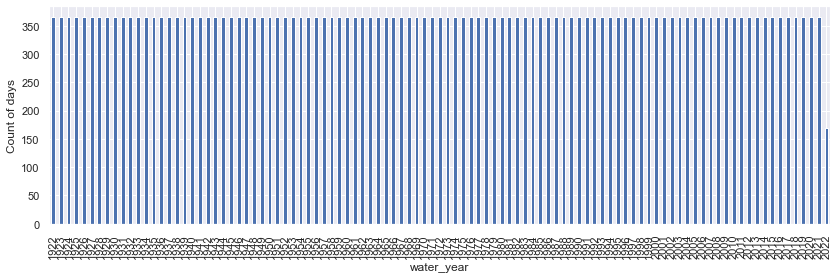

In [20]:
# Note this has a multiple index
plt.figure(figsize=(14,4))
plt.ylabel("Count of days")
wateryear['Q_af','count'].plot(kind='bar')

### let's look at statistics to see if there are any missing days prior to 2020 (the current partial year)?

In [21]:
wateryear.loc[wateryear.index<2020].describe()

Q                                   Q_cfd                \
            count          mean           sum       count          mean   
count   98.000000     98.000000  9.800000e+01   98.000000  9.800000e+01   
mean   365.244898  14630.007140  5.343580e+06  365.244898  1.264033e+09   
std      0.432238   4982.519272  1.820094e+06    0.432238  4.304897e+08   
min    365.000000   3324.584699  1.216798e+06  365.000000  2.872441e+08   
25%    365.000000  11472.993207  4.190512e+06  365.000000  9.912666e+08   
50%    365.000000  12694.657534  4.639820e+06  365.000000  1.096818e+09   
75%    365.000000  18145.579441  6.636775e+06  365.000000  1.567778e+09   
max    366.000000  28237.978142  1.033510e+07  366.000000  2.439761e+09   

                           Q_af                              
                sum       count          mean           sum  
count  9.800000e+01   98.000000     98.000000  9.800000e+01  
mean   4.616853e+11  365.244898  29018.262598  1.059886e+07  
std    1.572561e+11    0.432238   9882.705540  3.610112e+06  
min    1.051313e+11  365.000000   6594.232724  2.413489e+06  
25%    3.620603e+11  365.000000  22756.402404  8.311779e+06  
50%    4.008804e+11  365.000000  25179.543823  9.202970e+06  
75%    5.734174e+11  365.000000  35991.314573  1.316388e+07  
max    8.929526e+11  366.000000  56009.341424  2.049942e+07

### Nice! 25% are leap years (mean is close to 365.25), and no years have less than 365 days

# Now let's evaluate with respect to the Compact. The compact states that each _year_ 7.5 Million acre feet must pass from the upper basin to the lower at Lee's Ferry. Was that happening prior to the dam being installed in the 1960s?

Text(0, 0.5, 'Q [acre feet] per year')

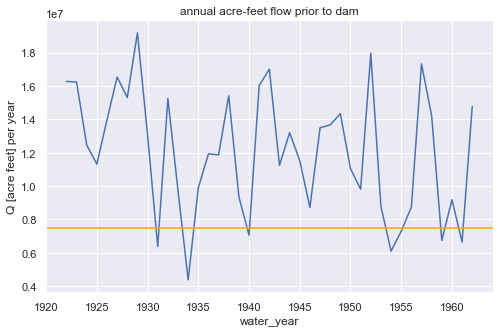

In [22]:
# look at the aggregated (using sum) Acre Feet per year prior to 1963
ax = wateryear['Q_af','sum'].loc[wateryear.index<1963].plot(figsize=(8,5))
ax.axhline(y=7.5e6, c='orange')
ax.set_title('annual acre-feet flow prior to dam')
ax.set_ylabel('Q [acre feet] per year')

Text(0, 0.5, 'Q [acre feet] per year')

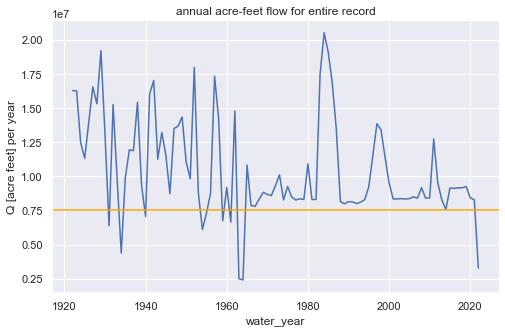

In [23]:
# What about looking at the entire record
ax = wateryear['Q_af','sum'].plot(figsize=(8,5))
ax.axhline(y=7.5e6, c='orange')
ax.set_title('annual acre-feet flow for entire record')
ax.set_ylabel('Q [acre feet] per year')

### Let's do some more exploration of the flow over all record

<AxesSubplot:xlabel='datetime'>

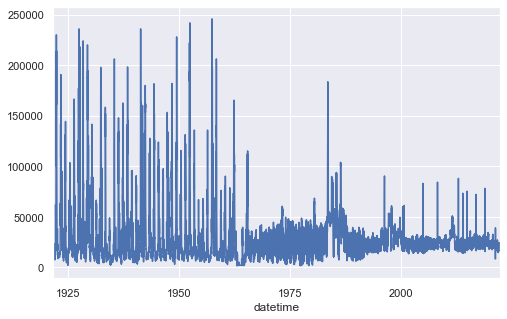

In [24]:
nwis_df.Q_af.plot(figsize=(8,5))

#### first we can apply functions to `groupby` grouping

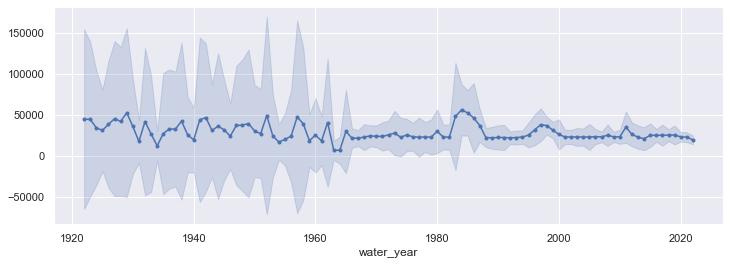

In [25]:
# calculate the mean Q in acre feet per day
mean_Q = nwis_df.groupby('water_year').Q_af.mean()
# calculate the standard deviation
CI = nwis_df.groupby('water_year').Q_af.std()
# make a filled plot representing the 95% interval around the mean
lower_CI = mean_Q - 2*CI
upper_CI = mean_Q + 2*CI
ax = mean_Q.plot(style='b.-', figsize=(12,4))
plt.fill_between(lower_CI.index,lower_CI,upper_CI, color='b',alpha = 0.2)

### can accomplish this in one step using `agg` for "aggregate"


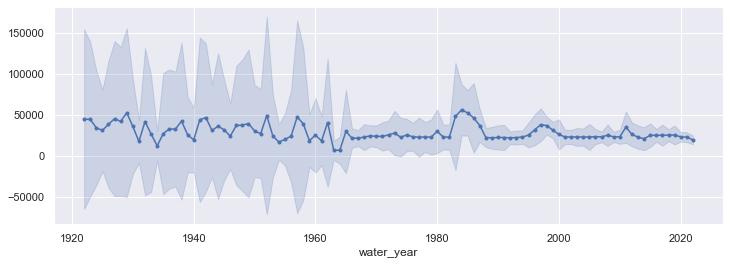

In [26]:
Q_agg = nwis_df.groupby('water_year').Q_af.agg([np.min, np.mean, np.std])

# make a function so we can try different aggregation strategies
def plot_agg(Q_agg): 
    mean_Q =Q_agg['mean'].apply(lambda x: np.max((x,0.01))) 
    lower_CI = mean_Q - 2*Q_agg['std'].apply(lambda x: np.max((x,0.01)))
    upper_CI = mean_Q + 2*Q_agg['std'].apply(lambda x: np.max((x,0.01)))
    ax = mean_Q.plot(style='b.-', figsize=(12,4))
    plt.fill_between(Q_agg.index,lower_CI,upper_CI, color='b',alpha = 0.2)
plot_agg(Q_agg)

In [27]:
Q_agg['std'].apply(lambda x: np.min((x,0.01)))

water_year
1922    0.01
1923    0.01
1924    0.01
1925    0.01
1926    0.01
        ... 
2018    0.01
2019    0.01
2020    0.01
2021    0.01
2022    0.01
Name: std, Length: 101, dtype: float64

### The variability certainly changed after the dam was filled. We can check out just standard deviation as a bar chart

<AxesSubplot:xlabel='water_year'>

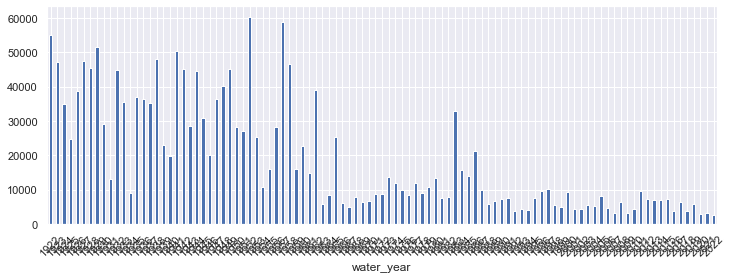

In [28]:
nwis_df.groupby('water_year').Q_af.std().plot(kind='bar',rot=45, figsize=(12,4))

### how hard to change from annual aggregation to monthly?

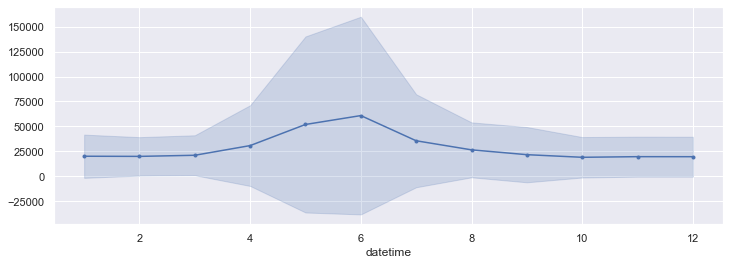

In [29]:
Q_agg_month = nwis_df.groupby(nwis_df.index.month).Q_af.agg([np.mean,np.std])
plot_agg(Q_agg_month)

### WAT? why only 12 monthly values? 
### We need two levels of grouping --- by year then by month

<AxesSubplot:xlabel='datetime,datetime'>

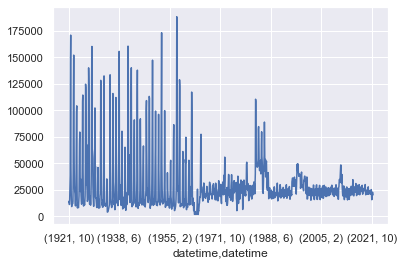

In [30]:
Q_agg_month = nwis_df.groupby([nwis_df.index.year,nwis_df.index.month]).Q_af.aggregate([np.mean,np.std])
Q_agg_month['mean'].plot()

# 4. We can use Fast Fourier Transform Analysis to further examine the changes in the behavior of the river after the dam was built

## Fourier analysis - so nerdy. so fun. Here's some background
https://youtu.be/spUNpyF58BY

### we have to detrend the data for `fft` to work properly. care why? read this: https://groups.google.com/forum/#!topic/comp.dsp/kYDZqetr_TU

### how do we do this? python is "batteries included" https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html

In [31]:
nwis_df['Q_detrend'] = sp_detrend(nwis_df.Q)

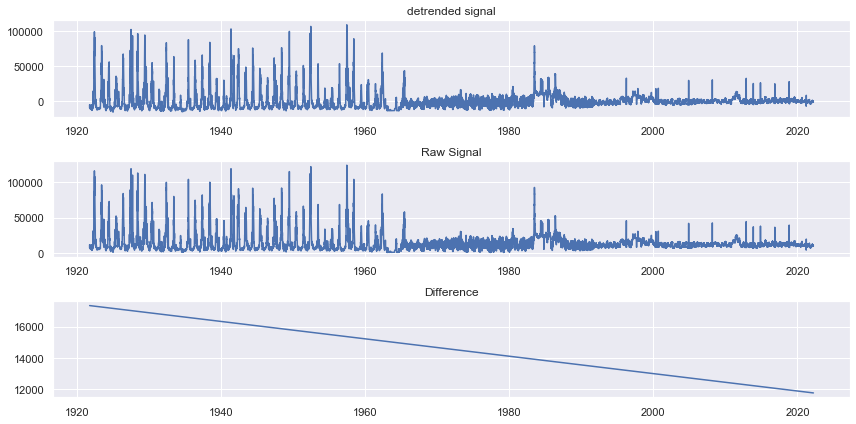

In [32]:
N = len(nwis_df)
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(3,1,1)
plt.plot(nwis_df.Q_detrend)
plt.title('detrended signal')

plt.subplot(3,1,2)
plt.plot(nwis_df.index,nwis_df.Q)
plt.title('Raw Signal')

plt.subplot(3,1,3)
plt.plot(nwis_df.index,nwis_df.Q-nwis_df.Q_detrend)
plt.title('Difference')

plt.tight_layout()

## Evaluate and plot the Period Spectrum to see timing of recurrence

### First make a function to perform the FFT and plot the spectrum for signals of various length

In [33]:
def fft_and_plot(df, plot_dominant_periods=4):
    N = len(df)
    yf = np.fft.fft(df.Q_detrend)
    yf = np.abs(yf[:int(N/2)])
    # get the right frequency 
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html#numpy.fft.fftfreq
    d = 1. # day
    f = np.fft.fftfreq(N,d)[:int(N/2)]
    f[0] = .00001
    per = 1./f # days
    fig = plt.figure(figsize=(12,6))
    ax = plt.subplot(2,1,1)
    plt.plot(per, yf)
    plt.xscale('log')

    top=np.argsort(yf)[-plot_dominant_periods:]
    j=(10-plot_dominant_periods)/10
    for i in top:
        plt.plot([per[i],per[i]],[0,np.max(yf)],'r:')
        plt.text(per[i],j*np.max(yf),'{0:.2f}'.format(per[i]))
        j+=0.1

    plt.title('Period Spectrum')
    plt.grid()
    ax.set_xlabel('Period (days)')
    plt.xlim([1, 1e4])

    plt.subplot(2,1,2)
    plt.plot(df.index,df.Q)
    plt.title('Raw Signal')
    plt.tight_layout()

### now we can look at the whole signal

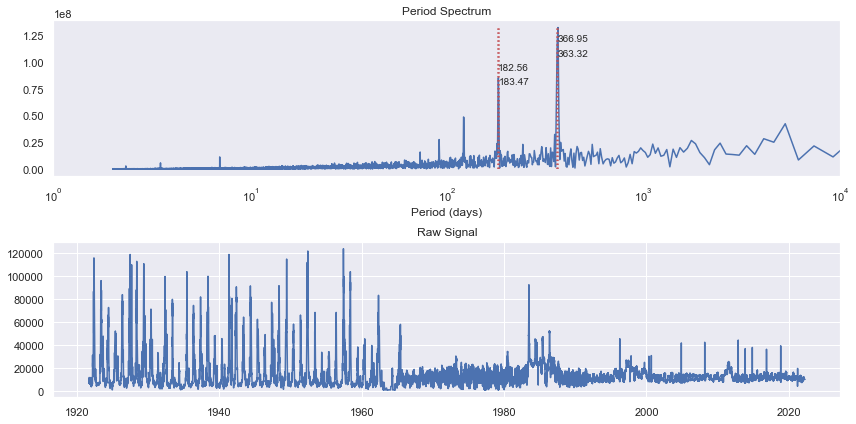

In [34]:
fft_and_plot(nwis_df)

### The dominant periods are all right around a year, which corresponds to the spring flood. The fourth most dominant peak is around half a year

### What about only the years before the dam?

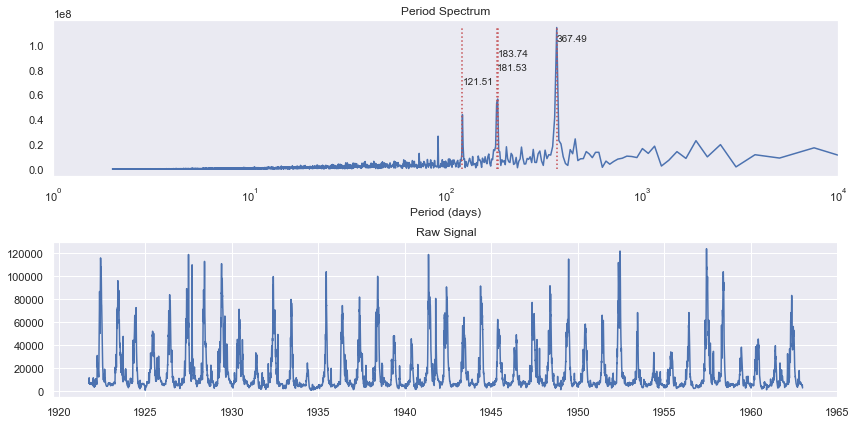

In [35]:
fft_and_plot(nwis_df.loc[nwis_df.index.year<1963])

### Again, the annual and biannual periods dominate

### did things change after the dam filled up in 1963?

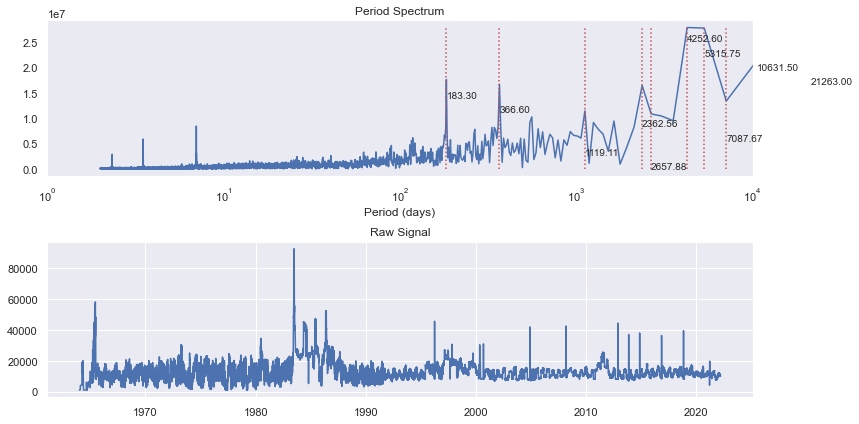

In [36]:
fft_and_plot(nwis_df.loc[nwis_df.index.year>1963], 10)

### These are more noisy with more unique events that imply very long periods

### What if we focus in on the heady days of grunge?

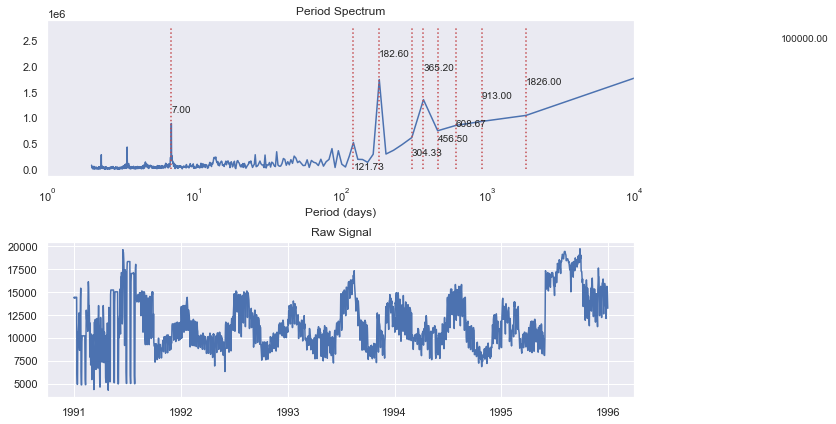

In [37]:
fft_and_plot(nwis_df.loc[(nwis_df.index.year>1990) & (nwis_df.index.year<1996)], 10)

### what's up with a dominant period of 7 days?

### let's check out a couple weeks of the signal

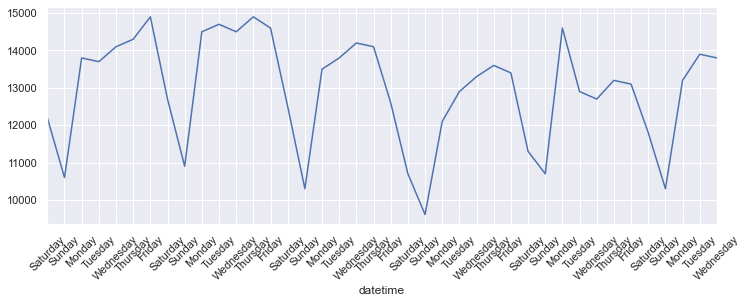

In [38]:
plt.figure(figsize=(12,4))
cfreq = 40
df = nwis_df.loc[nwis_df.index.year>1993]
df.iloc[:cfreq].Q.plot(rot=45, grid=True)
plt.xticks(df.iloc[:cfreq].index,df.iloc[:cfreq].index.day_name());

### looks like weekday power generation with lover flow on the weekends!

### finally, how does recent time look?

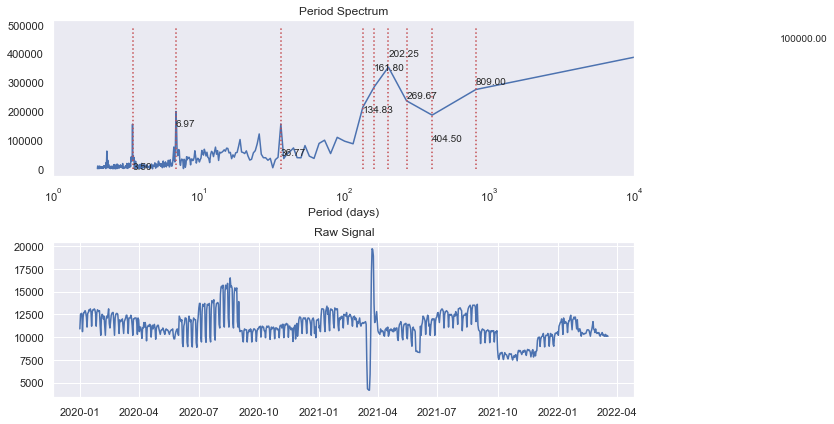

In [39]:
fft_and_plot(nwis_df.loc[nwis_df.index.year>2019], 10)

### So, in recent times, weekly power-generation periods are way more dominant than the former annual signal under natural conditions